## Import Dependencies

In [126]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
import sqlite3 #for querying data 
from datetime import datetime


# Data Visualization Libraries:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import statsmodels.api as sm

# Data Analysis: Statistics and Machine Learning Libraries
from scipy import stats
import scikit_posthocs as sp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Import Dataset
 - Data downloaded from https://data.lacity.org/resource/63jg-8b9z.json on 12/3/19

In [2]:
# import data using read_csv() method
df = pd.read_csv("/Users/trinitycisneros/Documents/Coding/bitterscientist.com/Crime_Data_from_2010_to_Present.csv")

## Filter Dataset

In [3]:
# This study will evaluate trends in weapon related crimes, and as such, will use the following features
weapon_crime_df = df[['Date Rptd', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Crm Cd 1', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'AREA NAME' , 'LAT', 'LON']]
# Renamed columns
weapon_crime_df.columns = ["Date_Reported", "Vict_Age", "Vict_Sex", "Vict_Desc", "Crime_Code", "Weapon_Code", "Weapon_Desc", "Status", "Area_Name", "Lat", "Lng"]

## Omit all records missing data

In [4]:
weapon_crime_df = weapon_crime_df.dropna(how='any', subset=['Weapon_Desc', 'Vict_Sex', 'Vict_Desc', 'Crime_Code', 'Status']).copy()

## Update Column Datatypes

In [5]:
# Create lists for categorical and int columns
cat_col = ['Vict_Sex', 'Vict_Desc', 'Weapon_Desc', 'Status', 'Area_Name']
int_col = ['Vict_Age', 'Weapon_Code', 'Crime_Code']
string_col = ['Date_Reported']

In [6]:
# Convert events column into int using a for loop
for col in int_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('int64')

In [7]:
# Convert events column into category using a for loop
for col in cat_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('category')

In [8]:
# Convert events column into category using a for loop
for col in string_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('str')

In [9]:
# Convert date_reported column into a datetime column
weapon_crime_df['Date_Reported'] =  pd.to_datetime(weapon_crime_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')

## Relabel categorical data

In [10]:
descent_dict = {'A' : 'Other Asian', 'B' : 'Black', 'C' : 'Chinese', 'D' : 'Cambodian', 'F' : 'Filipino', 'G' : 'Guamanian', 'H' : 'Hispanic/Latin/Mexican', 'I' : 'American Indian/Alaskan Native', 'J' : 'Japanese', 'K' : 'Korean', 'L' : 'Laotian', 'O' : 'Other', 'P' : 'Pacific Islander', 'S': 'Samoan', 'U': 'Hawaiian', 'V': 'Vietnamese', 'W': 'White', 'X': 'Unknown', 'Z':'Asian Indian'}

In [11]:
weapon_crime_df['Vict_Desc'].replace(descent_dict, inplace= True)

## Filter out 2019 values (as it is incomplete)

In [12]:
end_year = '2019-01-01'
mask = weapon_crime_df['Date_Reported'] < end_year
weapon_df = weapon_crime_df.loc[mask]

### Research Questions
### What are the top 10 crimes involving weapons
### What are the top 10 weapons reported in crimes
### What are general features of the all victims
### How have weapon related crimes changed over the reporting period
 - What are the victim profiles
 - What was the crime reported
### In the past year, where were these crimes committed?
### In the past year, are there regional differences in weapon usage accross the city?
### How does a regions annual household income affect weapon related crimes?

## What are the top 10 crimes involving weapons

In [13]:
# Get the top 10 crimes
wc_top_10 = weapon_df['Crime_Code'].value_counts()[0:9]

In [14]:
# To rename the crime codes with their crime description prepare a list of crimes
index_ = ['Battery - misdemeanor', 'Spousal/Cohab Abuse - Simple Assault', 'Assault with a Deadly Weapon', 'Robbery', 'Criminal Threats', 'Spousal beating', 'Brandishing', 'Robbery - attempted', 'Assault on Firefighter or Peace Officer With Deadly Weapon']

In [15]:
# Set the index 
wc_top_10.index = index_

In [16]:
# Prepare a dataframe
wc_top_10_df = pd.DataFrame(wc_top_10)

In [17]:
# Rename column
wc_top_10_df.columns=["Total Count"]
wc_top_10_df

,Total Count
Battery - misdemeanor,170812
Spousal/Cohab Abuse - Simple Assault,96159
Assault with a Deadly Weapon,81631
Robbery,75130
Criminal Threats,44077
Spousal beating,12419
Brandishing,12083
Robbery - attempted,10743
Assault on Firefighter or Peace Officer With Deadly Weapon,9857


## What are the top 10 weapons reported in crimes

In [18]:
# Get the top 10 crimes
# Dataset: Original Weapon DF
weapon_top_10 = weapon_df['Weapon_Desc'].value_counts()[0:9]

In [19]:
# Extract just the categories and store them in a list
# Dataset: the filtered original weapon df from above
top_10_weapons = list(weapon_top_10.index.values.tolist())

In [20]:
# Create a small dataframe that will just contain summary data
# Using the filtered database weapon_top_10
weapon_top_10_df = pd.DataFrame(weapon_top_10)
weapon_top_10_df.columns=["Total Count"]
weapon_top_10_df

,Total Count
"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",382711
VERBAL THREAT,52204
UNKNOWN WEAPON/OTHER WEAPON,50293
HAND GUN,30272
SEMI-AUTOMATIC PISTOL,11789
KNIFE WITH BLADE 6INCHES OR LESS,11339
OTHER KNIFE,8482
UNKNOWN FIREARM,7019
VEHICLE,6435


## How have the top 10 weapons reported in crimes changed over time
 - Create a dataframe that has grouped data by weapon, and then aggregate by year, and count the number of events within each weapon category
 - generate line plots for each weapon category

In [106]:
# Group dataframe by weapon, and downsample to just show years
grouped = weapon_df.groupby('Weapon_Desc').resample('Y', on = "Date_Reported").count()
# Group by the crime_code column, but the values in each column are the same, 
# as it is aggregated by .count()
grouped_df = grouped[['Crime_Code']]
# Then convert index values to columns using the .reset_index()
all_weapons_df = grouped_df.reset_index()
# Reduce the date column to just the year (omit the month and last day of the month)
all_weapons_df['Date_Reported'] = all_weapons_df['Date_Reported'].dt.year
# Rename columns
all_weapons_df.rename(columns={'Weapon_Desc': 'Weapon','Date_Reported':'Year', 'Crime_Code': 'Annual_Total'}, inplace=True)

### Prepare data for plotting
 - Filter the all_weapons_df to only the top 10 weapons reported in crimes
 - use the top_10_weapons list generated above and convert that into an array
 - then use a for loop to filter the database and then create a new dataframe with just 
 - the top 10 weapons

In [60]:
# Convert top_10_weapons list into an array
array = np.asarray(top_10_weapons)

In [61]:
# Create a dataframe that only contains the top 10 weapons
frames = []
for value in array:
    temp_df = all_weapons_df.loc[test_df["Weapon"] == value]
    frames.append(temp_df)

In [62]:
# Concatenate the filtered dataframe
top10weapons = pd.concat(frames, axis=0)
# Convert the Weapon column from category to object, otherwise, the plots will contain
# every weapon category, when we just want the top 10 in the array generated above.
top10weapons = top10weapons.astype({'Weapon': 'str'})

### Display weapon related crimes in LA between 2010 - 2018 (Aggregated Plot)

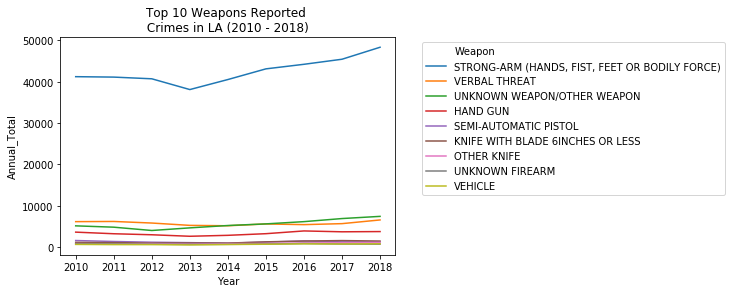

In [111]:
sns.lineplot(x="Year", y="Annual_Total", hue="Weapon", data=top10weapons)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1), ncol=1)
plt.title("Top 10 Weapons Reported \n Crimes in LA (2010 - 2018) ")
plt.savefig("static/images/combined_top_weapons_line_plots.png", bbox_inches='tight')
plt.show()

### Display weapon related crimes in LA between 2010 - 2018 (Individual Plots)

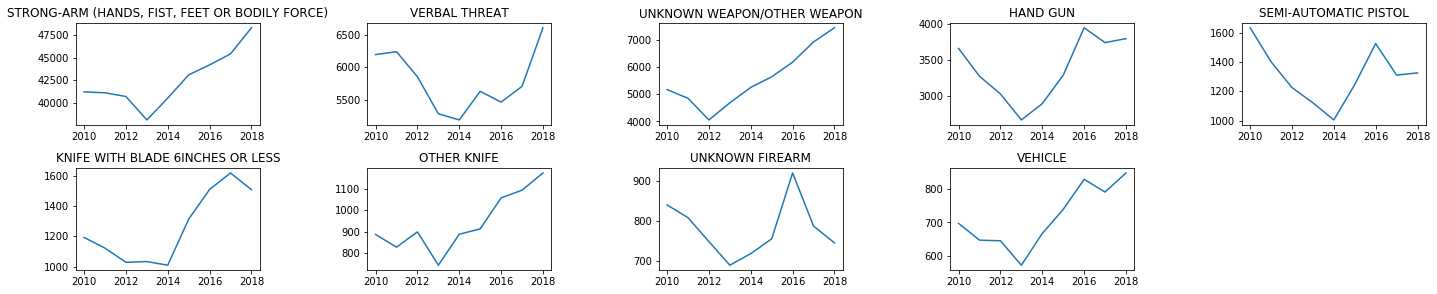

In [113]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.8, wspace=0.2)
for c,num in zip(array, range(1,10)):
    df0=top10weapons[top10weapons['Weapon']==c]
    ax = fig.add_subplot(5,5, num)
    ax.plot(df0['Year'], df0['Annual_Total'])
    ax.set_title(c)

plt.tight_layout()
plt.savefig("static/images/top_weapons_line_plots.png", bbox_inches='tight')
plt.show()

## What are general features of the all victims
 - Age
 - Sex
 - Age by Sex

### Descriptive statistics of ALL victim ages
 - Create a subset that only include the Victim Age

In [117]:
# Descriptive statistics for victim age for all sexes
weapon_df[['Vict_Age']].describe()

,Vict_Age
count,630354.000000
mean,32.980089
std,16.653620
min,-7.000000
25%,22.000000
50%,31.000000
75%,44.000000
max,99.000000


### Descriptive statistics of victim ages by Sex

In [118]:
# Find out what is the age descriptive statistics by sex
vict_age_by_sex = weapon_df.groupby('Vict_Sex')['Vict_Age'].describe()
# Drop non M or F categories
vic_age_by_sex = vict_age_by_sex.drop(['H', 'N', 'X'])
vic_age_by_sex

,count,mean,std,min,25%,50%,75%,max
Vict_Sex,,,,,,,,
F,324520.0,32.918615,15.138958,-7.0,22.0,30.0,43.0,99.0
M,298764.0,33.757200,17.674980,-6.0,22.0,32.0,47.0,99.0


## Visualize distribution of the ages of victims in weapon related crimes

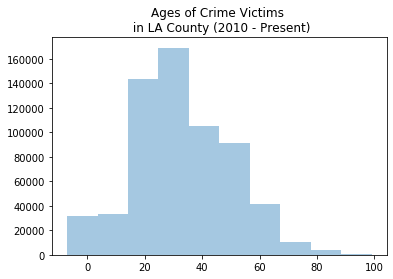

In [119]:
# Plot all the victim age for all victims
sns.distplot(weapon_df[['Vict_Age']], bins=10, kde=False).set_title('Ages of Crime Victims \n in LA County (2010 - Present)')
plt.savefig("static/images/plot_vict_age_all_histogram.png", bbox_inches='tight')
plt.show()

## Visualize distribution of the ages of victims of weapon related crimes filtered for either Female or Male.

In [120]:
# Subset data by victim sex for only known sexes
all_F_age_data = weapon_df.loc[weapon_df["Vict_Sex"] == "F"][['Vict_Age']]
# array with the female data
female_data = all_F_age_data['Vict_Age'].values
all_M_age_data = weapon_df.loc[weapon_df["Vict_Sex"] == "M"][['Vict_Age']]
# array with the male data
male_data = all_F_age_data['Vict_Age'].values

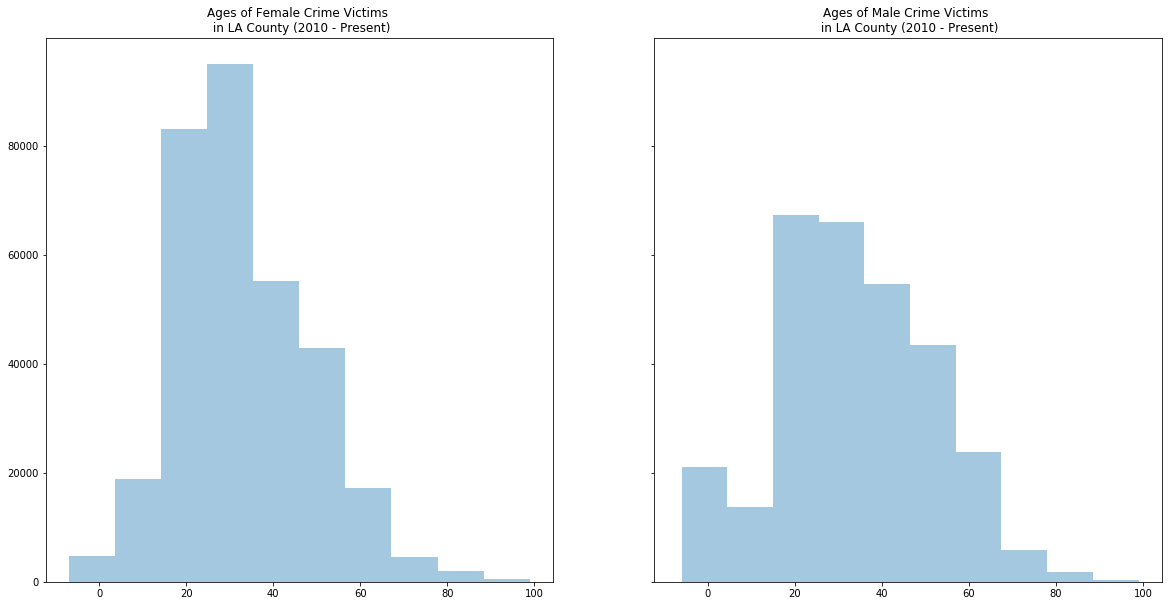

In [121]:
# Plot all the victim age for all victims
fig1, axs1 = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 10))
sns.distplot(all_F_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[0]).set_title('Ages of Female Crime Victims \n in LA County (2010 - Present)')
sns.distplot(all_M_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[1]).set_title('Ages of Male Crime Victims \n in LA County (2010 - Present)')
fig1.savefig("static/images/plot_vict_age_by_sex_histograms.png", bbox_inches='tight')
plt.show()

## Determine if there is a difference in the mean number of crimes between male and female

### Test for normality and equal variance
 - cannot use a shapiro-wilk test because the p value will not be accurate with N > 5000

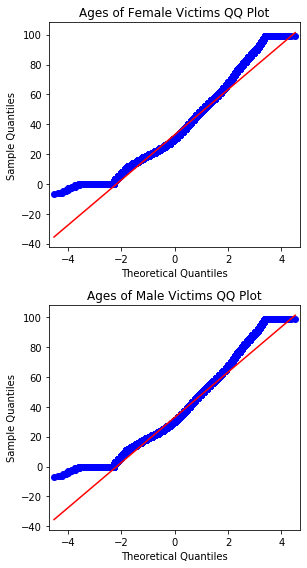

In [129]:
import scipy.stats as stats
left = -1.8
fig = plt.figure(figsize=(8,8))

# qq plot for female victims
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(female_data, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
ax.title.set_text('Ages of Female Victims QQ Plot')

# qq plot for male victims
ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(male_data, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
ax.title.set_text("Ages of Male Victims QQ Plot")

fig.tight_layout()
fig.savefig("static/images/plot_vict_age_by_sex_qq_plots.png", bbox_inches='tight')
plt.show()

In [130]:
# Test for equal variance
# scipy.stats.bartlett because I know the samples are normally distributed
barlette_result = stats.bartlett(female_data, male_data)
if barlette_result[1] >= 0.05:
    print("Do not reject the null hypothesis, all the input samples are from populations with equal variances.")
else:
    print("Reject the null hypothesis, the samples do not have equal variance")

Do not reject the null hypothesis, all the input samples are from populations with equal variances.


### t-test for two indepedent samples

In [131]:
vict_sex_t_test = stats.ttest_ind(female_data,male_data)
if vict_sex_t_test[1] >= 0.05:
    print(f"The p values is {vict_sex_t_test[1]}. Do not reject the null hypothesis.")
else:
    print(f"The p values is {vict_sex_t_test[1]}. Reject the null hypothesis, the samples significantly different.")

The p values is 1.0. Do not reject the null hypothesis.


## <font color='red'>No significant difference in the mean age of victims by sex.</font>

## Explore the ethnic/racial makeup of victims of weapon related crimes

In [132]:
# Get the top 10 victims of weapon related crimes by their descendant category
top10_vict_desc = weapon_df['Vict_Desc'].value_counts()[0:10]
top10_vict_desc_df = pd.DataFrame(top10_vict_desc)
top10_vict_desc_df.columns=["Total_Count"]
top10_vict_desc_df

,Total_Count
Hispanic/Latin/Mexican,298815
Black,151994
White,110371
Other,42712
Other Asian,11282
Unknown,11128
Korean,2867
Filipino,591
American Indian/Alaskan Native,187
Chinese,130


### Prepare victim ethnic data for visualization

In [134]:
# Make a list of the top 10 victim descent
# This will be the axist category for the bar plot
desc_cat = list(top10_vict_desc_df.index.values.tolist()) 

In [135]:
# Prepare a list of the number of victims per descent category (in descending order)
# This will be the height value for the bar plot
vic_desc_values = top10_vict_desc.values.tolist()

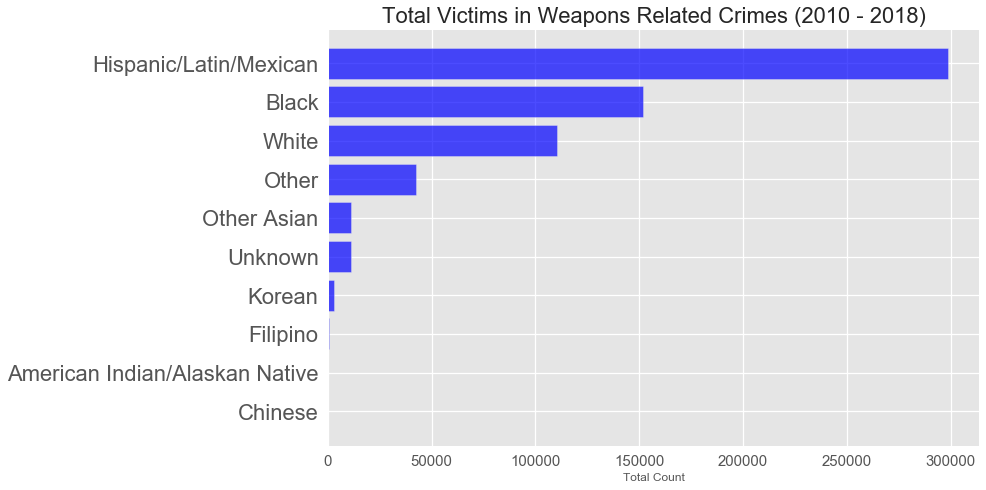

In [357]:
# plt.rcdefaults()
plt.style.use('ggplot')
fig, ax = plt.subplots()
plt.rc('axes', titlesize=22)
plt.rc('ytick', labelsize=22)

# Example data
y = desc_cat
y_pos = np.arange(len(desc_cat))

ax.barh(y_pos, vic_desc_values, align='center', color='blue', alpha = 0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total Count')
ax.set_title("Total Victims in Weapons Related Crimes (2010 - 2018)")
plt.savefig("static/images/plot_all_crimes_by_vict_desc.png", bbox_inches='tight') 

plt.show()

## <Font color='red'>The majority of victims of weapon related crimes are Hispanic, Black, and White individuals</Font>

## What crimes were the weapons used?
 - Data: List of the top 10 crimes by count: wc_top_10_df (need to get the index) 
 - Filter weapon_df by the names on this list
 - Aggregate data

In [150]:
# Step 1: Create a dataframe that contains only a subset of columns
prep_crime_df_1 = weapon_df[['Date_Reported', 'Crime_Code', 'Weapon_Desc']].copy()

In [ ]:
# Step 2: Filter out rows that do not contain the top to crime codes

In [154]:
# Extract the index (crime codes)
top_10_crime_codes = list(weapon_df['Crime_Code'].value_counts()[0:9].index.values.tolist())
crime_array = np.asarray(top_10_crime_codes)

In [156]:
# Create a dataframe that only contains the top 10 weapons
crime_frames = []
for value in crime_array:
    temp_df = prep_crime_df_1.loc[prep_crime_df_1["Crime_Code"] == value]
    crime_frames.append(temp_df)

In [158]:
# Concatenate the filtered dataframe
top10crimes_by_weapon = pd.concat(crime_frames, axis=0)

In [161]:
# Rename columns
top10crimes_by_weapon.rename(columns={'Weapon_Desc': 'Weapon','Date_Reported':'Year'}, inplace=True)

In [162]:
# Drop the month and day in the year column
top10crimes_by_weapon['Year'] = top10crimes_by_weapon['Year'].dt.year

In [163]:
# Convert the Weapon column from category to object, otherwise, the plots will contain
# every weapon category, when we just want the top 10 in the array generated above.
top10crimes_by_weapon = top10crimes_by_weapon.astype({'Weapon': 'str'})

In [170]:
# Dictionary of crime codes and their text description (ucr reporting dictionary available online)
crimes_dict = {624 : 'Battery - misdemeanor', 626 : 'Spousal/Cohab Abuse - Simple Assault', 230 : 'Assault with a Deadly Weapon', 210 : 'Robbery', 930 : 'Criminal Threats', 236 : 'Spousal beating', 761 : 'Brandishing', 220 : 'Robbery - attempted', 310 :  'Assault on Firefighter or Peace Officer With Deadly Weapon'}

In [171]:
# Replace crime codes with crime description
top10crimes_by_weapon['Crime_Code'].replace(crimes_dict, inplace= True)

### Filter database by top 10 weapon! Otherwise we get everything
 - Use the array list that contains the top 10 weapons
 - Use the top10crimes_by_weapon dataframe

In [185]:
# Create a dataframe that only contains the top 10 weapons
new_frames = []
for value in array:
    temp_df = top10crimes_by_weapon.loc[top10crimes_by_weapon["Weapon"] == value]
    new_frames.append(temp_df)

In [188]:
# Concatenate the filtered dataframe
top10crimes_weapons_df = pd.concat(new_frames, axis=0)

In [314]:
# Create a pivot table to summarize the counts of each event
weapon_crime_table = pd.pivot_table(top10crimes_weapons_df, values='Year', index=['Crime_Code'], columns=['Weapon'], aggfunc='count')
weapon_crime_table

Weapon,HAND GUN,KNIFE WITH BLADE 6INCHES OR LESS,OTHER KNIFE,SEMI-AUTOMATIC PISTOL,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",UNKNOWN FIREARM,UNKNOWN WEAPON/OTHER WEAPON,VEHICLE,VERBAL THREAT
Crime_Code,,,,,,,,,
Assault on Firefighter or Peace Officer With Deadly Weapon,27,27,20,10,2224,5,6689,5,17
Assault with a Deadly Weapon,11637,4660,3626,4253,11726,3216,8948,5093,326
Battery - misdemeanor,67,118,62,20,156835,14,8800,139,337
Brandishing,2570,1638,1137,757,297,231,346,6,804
Criminal Threats,400,454,296,132,1719,29,766,27,38519
Robbery,10373,2713,1948,4708,37990,486,2416,135,2334
Robbery - attempted,964,531,372,425,5316,66,481,12,404
Spousal beating,226,422,288,78,7655,19,956,303,67
Spousal/Cohab Abuse - Simple Assault,45,213,141,20,90154,2,3144,75,181


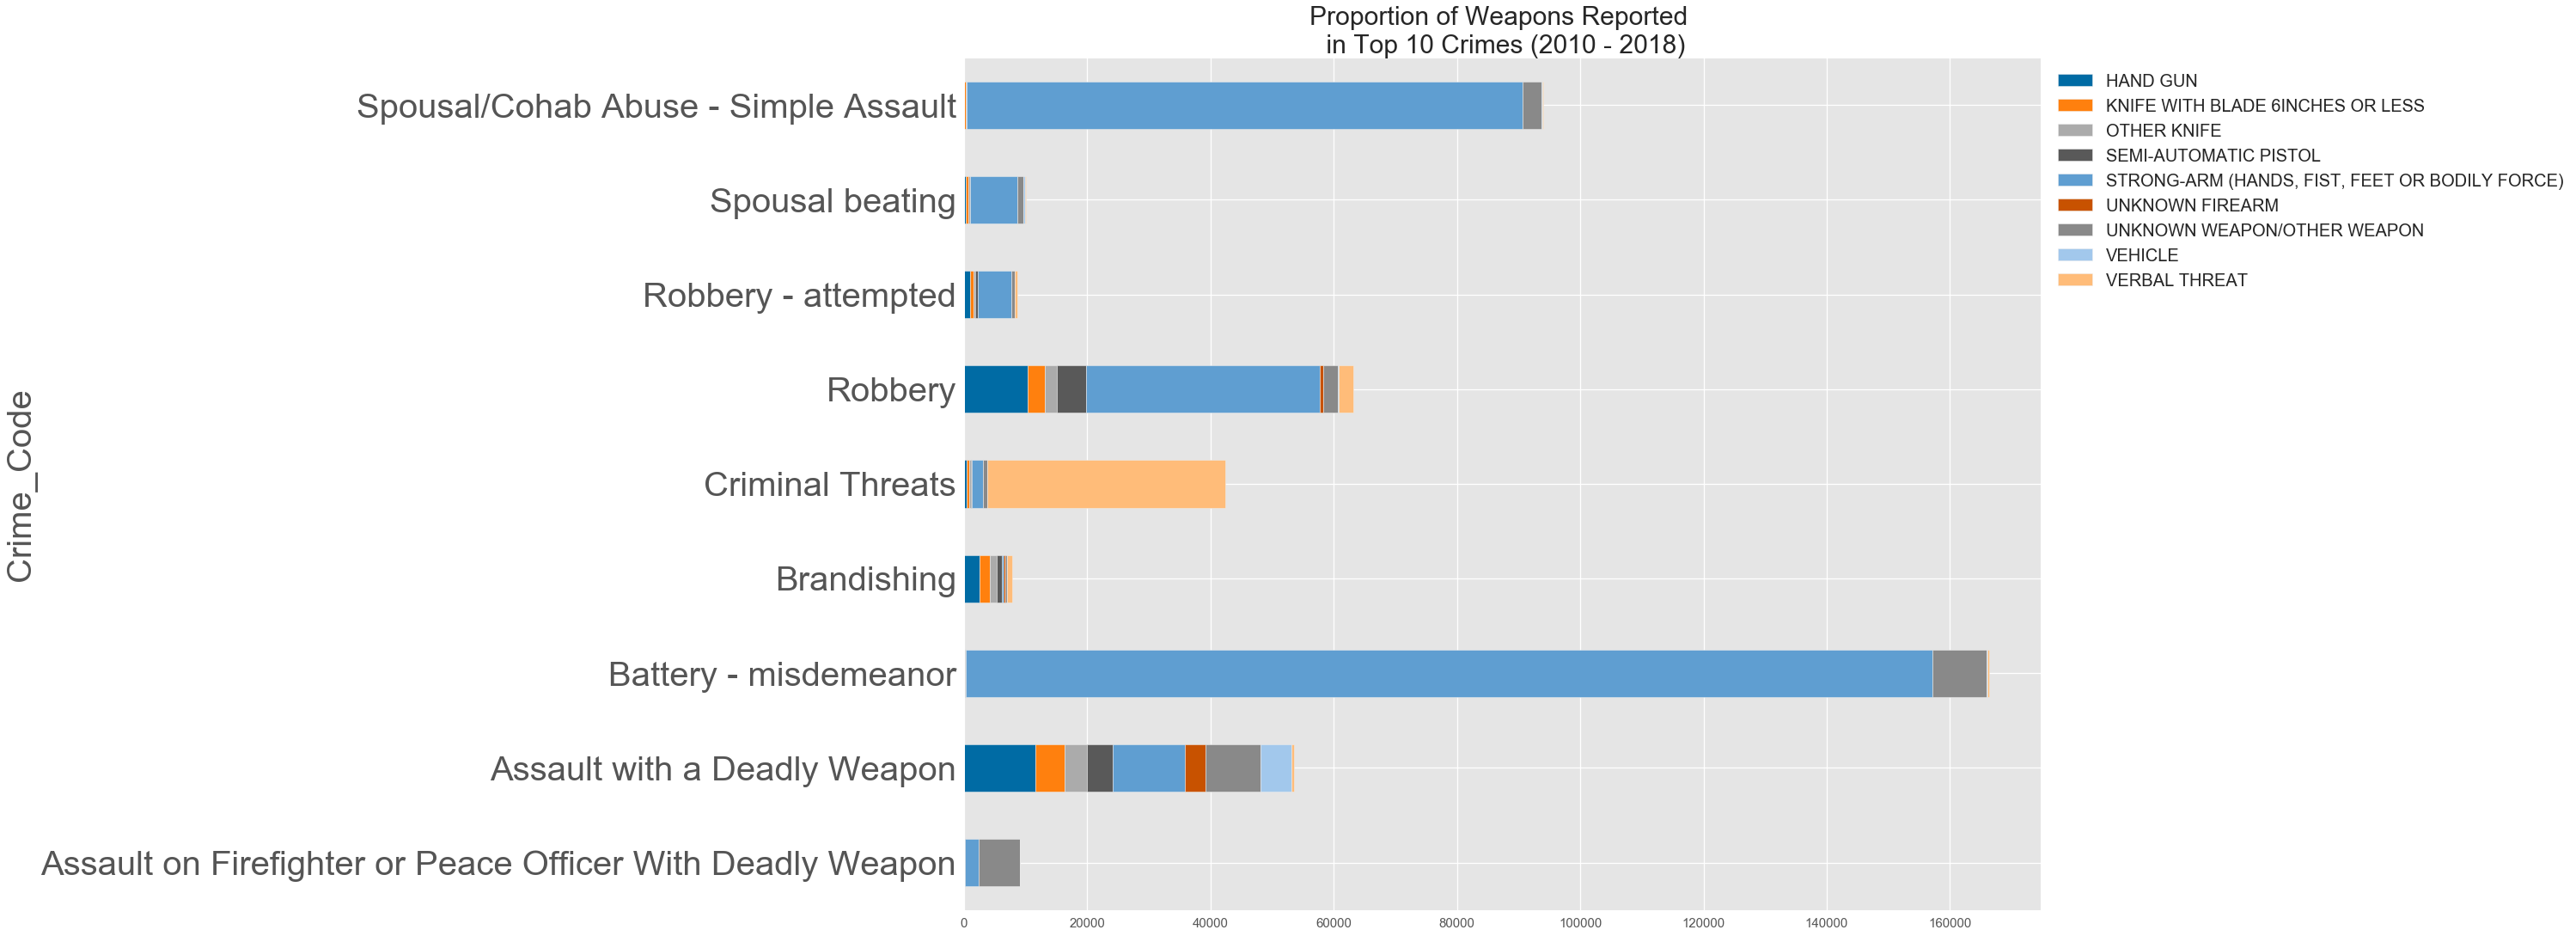

In [360]:
plt.style.use('tableau-colorblind10')
weapon_crime_table.plot.barh(stacked=True, figsize=(20,17))
plt.rcParams.update({'axes.titlesize': 30})
plt.rcParams.update({'axes.labelsize': 40})
plt.rcParams.update({'ytick.labelsize': 40})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rc('legend',**{'fontsize':20})
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), ncol=1)
plt.title("Proportion of Weapons Reported \n in Top 10 Crimes (2010 - 2018)")
plt.savefig("static/images/plot_weapon_crime_pivot_barh.png", bbox_inches='tight') 
plt.show()

## In the past year, where were these crimes committed?
 - Will need top 10 crimes
 - location of crimes
 - color code by weapon?

In [374]:
# Create a dataframe that contains the following fields
crime_location = weapon_df[['Date_Reported', 'Crime_Code', 'Weapon_Desc', 'Area_Name', 'Lat', 'Lng']].copy()

In [375]:
# Create a dataframe that only contains the top 10 weapons
crime_loc_frames = []
for value in crime_array:
    temp_df = crime_location.loc[crime_location["Crime_Code"] == value]
    crime_loc_frames.append(temp_df)

In [378]:
# Create subset dataframe with to 10 crimes
crime_loc_frames_df = pd.concat(crime_loc_frames, axis=0)

In [380]:
# Clean data
crime_loc_frames_df['Crime_Code'].replace(crimes_dict, inplace= True)
# crime_location['Crime_Code'] = crime_location['Crime_Code'].astype(str)

In [382]:
crime_loc_frames_df['Crime_Code'].unique()

array(['Battery - misdemeanor', 'Spousal/Cohab Abuse - Simple Assault',
       'Assault with a Deadly Weapon', 'Robbery', 'Criminal Threats',
       'Spousal beating', 'Brandishing', 'Robbery - attempted',
       'Assault on Firefighter or Peace Officer With Deadly Weapon'],
      dtype=object)

Convert the date column into a year
Export to csv
then work with javascript to create a map that can be filtered by year and will plot the crimes by lat and lng and also color code it by weapon

## In the past year, are there regional differences in weapon usage accross the city?

## How does a regions annual household income affect weapon related crimes?